# Frequency-Accuracy Analysis

This notebook analyze the relationship between the frequency of the signal and the predicted accuracy of the hypnosis depth. This analysis is done response to the following reviewer's comment:

"The fact that higher frequency components contribute more to the prediction of the hypnosis depth suggest a more general relationship between hypnosis and the EEG spectrum. It would have been informative to plot a frequency – accuracy plot where frequency is divided in narrow frequency intervals with a logarithmic granularity from 1 Hz up to 60 Hz on the y-axis and prediction accuracy represented on the x-axis. The deviation of that curve would be interesting to analyze relative to the linear function. Would we see steps with the conventional delta, theta, alpha, beta and gamma bands?"

## Setup

In [1]:
# imports
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import mne

# constants
epochs = mne.read_epochs('data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif')
ch_names = epochs.ch_names.copy()  # make sure to copy the list because it is mutable in place
[ch_names.remove(i) for i in ['M1', 'M2', 'EOG1', 'EOG2', 'ECG']]
all_channels = epochs.ch_names
del epochs

# name of electrode groups
ba_patches = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5'],
 'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5', 'FT7'],
 'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
 'LO': ['O1', 'PO3'],
 'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6',],
 'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6', 'FT8'],
 'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
 'RO': ['O2', 'PO4'],
 'FZ': ['Fpz', 'Fz'],
 'CZ': ['Cz', 'FCz'],
 'PZ': ['Pz', 'CPz'],
 'OZ': ['POz', 'Oz', 'Iz'],
 'all': ch_names
}

# index of electrode groups
rois = {}
for k,v in ba_patches.items():
    temp = [all_channels.index(i) for i in v]
    rois[k] = temp

Reading /Users/yeganeh/Codes/SugNet/data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated


## Feature extraction

### Power Sensor

In [3]:
# open power sensor
with open(f'docs/psds_3th_higher_frequency_resolution.pkl', 'rb') as f:
    psds = pkl.load(f)

def constant_q_bins(fmin=1.0, fmax=42.0, bins_per_oct=6):
    centers = []
    f = fmin
    while f <= fmax:
        f *= 2**(1/bins_per_oct)
        centers.append(f)
    centers = np.array(centers)
    width = 2**(1/(2*bins_per_oct))
    edges = np.column_stack([centers/width, centers*width])
    edges[:, 0] = np.maximum(edges[:, 0], fmin)
    edges[:, 1] = np.minimum(edges[:, 1], fmax)
    return centers, edges  # (n_bins,), (n_bins,2)

freqs = psds.pop('freqs')

In [ ]:
roi_features_all = {}
DB = False
RELATIVE = False
for key in psds.keys():

    # Interpolate PSD onto dense frequency grid
    psd = psds[key]  # (n_channels, n_freqs)
    freq_dense = np.arange(1, 42, 0.02)
    psd_dense = np.array([np.interp(freq_dense, freqs, psd[i]) for i in range(psd.shape[0])])

    centers, edges = constant_q_bins(1.0, 42.0, bins_per_oct=6)

    # 1) Bin power per channel (physical approach)
    bin_vals = []
    for f1, f2 in edges:
        m = (freq_dense >= f1) & (freq_dense <= f2)
        # integrate linear PSD then divide by bandwidth
        bw = (f2 - f1)
        # trapezoidal integral per channel
        p_lin = np.trapezoid(psd_dense[:, m], freq_dense[m], axis=1) / bw
        if DB:
            p_db  = 10*np.log10(p_lin + 1e-20)  # (n_channels,)
        bin_vals.append(p_lin)
    bin_vals = np.stack(bin_vals, axis=1)  # (n_channels, n_bins)

    # 2) ROI average in dB
    roi_features = []
    for roi_name, ch_idx in rois.items():
        roi_features.append(np.nanmean(bin_vals[ch_idx, :], axis=0))  # (n_bins,)
    roi_features = np.stack(roi_features, axis=1)  # (n_bins, n_rois)

    # # 3) convert to relative power across bins (per ROI)
    if RELATIVE:
        roi_features = (roi_features - roi_features.mean(axis=0, keepdims=True)) / roi_features.std(axis=0, keepdims=True)

    roi_features_all[key] = roi_features

## Classification

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API") # Supress dependancies warning till new sklearn versions is released

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [32]:
max_acc = {}
for freq_bin in range(33):
    print(f'>>> {freq_bin}')
    df = pd.DataFrame([])
    for key in roi_features_all.keys():
        df = pd.concat([df, pd.DataFrame(roi_features_all[key][freq_bin], columns=[key], index=list(rois.keys())).T], axis=0)

    df.reset_index(inplace=True)
    df[['bids_id', 'condition']] = df['index'].apply(lambda x: x.split('_')).apply(pd.Series)
    df.drop(columns='index', inplace=True)
    df['session'] = df['condition'].apply(lambda x: x[-1])

    # open session data and merge with power values
    session_data = pd.read_csv('data/behavioral_data/archived/behavioral_data.csv')
    df = df.astype({'session': 'int64'})
    df = pd.merge(session_data, df, how='right', on=['session', 'bids_id'], right_index=False)
    df.insert(1, 'condition', df.pop('condition'))

    # DATA
    df_cls = df.query('description == "hypnosis"').reset_index(drop=True)
    X = df_cls[list(rois.keys())].values
    y = df_cls['hypnosis_depth'].apply(lambda x: 0 if x<=5 else 1).values
    groups = df_cls['bids_id'].values

    # MODEL
    pipe = Pipeline(steps=[
        ('scale', StandardScaler()),
        ('cls', SVC(max_iter=10000000, kernel='linear', class_weight='balanced'))
        ])

    CV = GroupShuffleSplit(50, test_size=0.2)

    grid_params = [{
        'cls__C': [0.1, 0.5, 1, 5, 10, 50, 100],
    }]

    grid = GridSearchCV(pipe, grid_params, cv=CV, scoring='accuracy', verbose=1, n_jobs=-1)
    grid.fit(X, y, groups=groups)

    grid_results = pd.DataFrame(grid.cv_results_)

    best_C_idx = grid_results['mean_test_score'].idxmax()
    acc_cols = [c for c in grid_results if 'split' in c]
    acc_cols.append('mean_test_score')

    accuracies = grid_results.loc[best_C_idx, acc_cols]
    max_acc[freq_bin] = accuracies

acc_df = pd.DataFrame.from_dict(max_acc, orient='index')
acc_mean = acc_df['mean_test_score']

# find min and max split accuracies in each row
min_acc = acc_df.filter(like='split').min(axis=1)
max_acc = acc_df.filter(like='split').max(axis=1)

acc_ci = pd.concat([min_acc, max_acc], axis=1).rename(columns={0: 'min',
                                                               1: 'max'})

>>> 0
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 1
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 2
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 3
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 4
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 5
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 6
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 7
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 8
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 9
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 10
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 11
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 12
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 13
Fitting 50 folds for each of 7 candidates, totalling 350 fits
>>> 14
Fitting 50 folds for each of 7 candid

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Power · Sensor'}, xlabel='Balanced accuracy', ylabel='Frequency (Hz, log scale)'>)

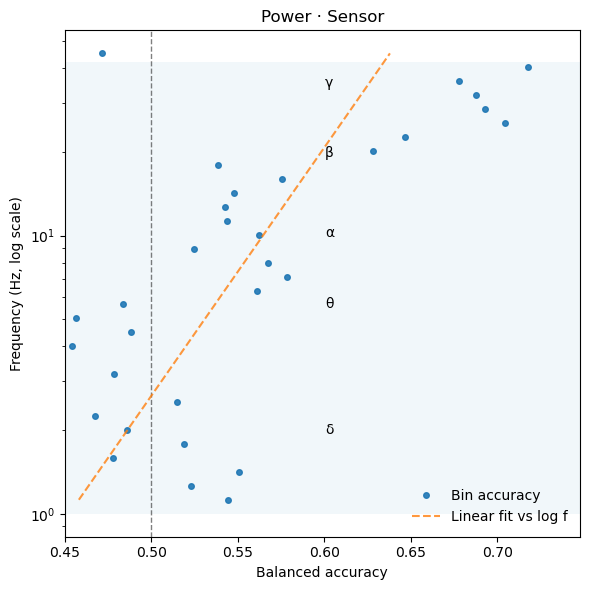

In [ ]:
def plot_freq_accuracy(freq_centers, acc_mean, acc_ci=None, title="Power · Sensor"):
    """
    freq_centers: (n_bins,) in Hz
    acc_mean:     (n_bins,) accuracy or balanced accuracy
    acc_ci:       (n_bins,2) lower/upper CI (optional)
    """
    f = np.array(freq_centers, float)
    a = np.array(acc_mean, float)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_yscale('log')

    # canonical bands (adjust to your limits)
    bands = [
        ("δ", 1, 4), ("θ", 4, 8), ("α", 8, 13),
        ("β", 13, 30), ("γ", 30, 42)
    ]
    for label, lo, hi in bands:
        ax.axhspan(lo, hi, alpha=0.06)  # gentle shading
        ax.text(0.505, (lo*hi)**0.5, label, va='center', ha='left', transform=ax.get_yaxis_transform())

    # points + horizontal error bars
    if acc_ci is not None:
        lo = acc_ci.loc[:, 'min']
        hi = acc_ci.loc[:, 'max']
        xerr = np.vstack([a - lo, hi - a])
        ax.errorbar(a, f, xerr=xerr, fmt='o', ms=4, capsize=2, alpha=0.9, label='Bin accuracy')
    else:
        ax.plot(a, f, 'o', ms=4, alpha=0.9, label='Bin accuracy')

    # chance & optional null band
    ax.axvline(0.5, ls='--', lw=1, alpha=0.5, color='k')   # chance for balanced acc
    # ax.axvspan(0.48, 0.52, color='k', alpha=0.05)        # null band from shuffles (if you have it)

    # linear trend vs log-frequency
    X = np.vstack([np.ones_like(f), np.log(f)]).T
    beta = np.linalg.lstsq(X, a, rcond=None)[0]
    a_hat = X @ beta
    ax.plot(a_hat, f, ls='--', lw=1.5, alpha=0.8, label='Linear fit vs log f')

    ax.set_xlabel('Balanced accuracy')
    ax.set_ylabel('Frequency (Hz, log scale)')
    ax.set_title(title)
    ax.set_xlim(max(0.45, a.min()-0.03), min(1.0, a.max()+0.03))
    ax.legend(loc='lower right', frameon=False)
    plt.tight_layout()
    return fig, ax

plot_freq_accuracy(centers, acc_mean)


In [ ]:
## why would we observe such a trend when not using non decibel transformed data? does it have to do with the 1/f??

# Gamma Coherency Analysis

This analysis is done in response to the following comment:

**I was missing a focus on analyzing the widespread gamma coherence across distant brain regions. The coherence of gamma is expected to decrease between regions as consciousness disintegrates. Under altered states of consciousness, such as observed in anesthesia ad or other drug induced states, gamma breaks down to local islands of coherent oscillation nodes over the cerebral cortex while distant regions decohere. Was that network dynamics analyzed but did not yield any difference in network coherence or this was disregarded for other reasons?**

### Setup 

In [ ]:
# IMPORTS
from scipy import stats
import re
from scipy.spatial.distance import cdist
import networkx as nx
import scipy.stats as st
import statsmodels.formula.api as smf

# HELPER FUNCTIONS

def get_gamma_cols(df, level):
    gamma_cols = [c for c in df.columns if 'gamma' in c]
    if level == 'sensor':
        FCz_cols = [c for c in df.columns if 'FCz' in c]
        gamma_cols = [c for c in gamma_cols if c not in FCz_cols] # remove those FCz columns because of the missing channel position (this is only important for the sensor data)
    return gamma_cols

def ensure_long_short_flags(edge_pairs, q_short=0.30, q_long=0.70):
    if "is_short" not in edge_pairs or "is_long" not in edge_pairs:
        q30, q70 = np.quantile(edge_pairs["dist"].values, [q_short, q_long])
        edge_pairs = edge_pairs.copy()
        edge_pairs["is_short"] = edge_pairs["dist"].values <= q30
        edge_pairs["is_long"]  = edge_pairs["dist"].values >= q70
    return edge_pairs

def mst_stats(edge_vec, N, i_idx, j_idx):
    e = np.asarray(edge_vec, float)
    # Convert to full matrix
    M = np.zeros((N, N))
    M[i_idx, j_idx] = e
    M[j_idx, i_idx] = e
    # tree that keeps **strongest** connections; nx.minimum_spanning_tree
    # minimizes sum of edge weights, so inverting weights to costs.
    with np.errstate(divide='ignore'):
        cost = 1.0 / (M + 1e-12)
    G = nx.from_numpy_array(cost)  # complete graph with costs
    T = nx.minimum_spanning_tree(G, algorithm='kruskal')
    # Recover original weights on tree edges:
    w_tree = []
    for u, v in T.edges():
        w_tree.append(M[u, v])
    # Metrics
    degs = np.array([d for _, d in T.degree()])
    leaf_fraction = np.mean(degs == 1)
    diameter = nx.diameter(T)
    strength = np.mean(w_tree)
    return leaf_fraction, diameter, strength

def per_row_metrics(conn, edge_pairs, level, N_nodes, i_idx, j_idx):
    edge_cols = get_gamma_cols(conn, level)
    dist_vec  = edge_pairs["dist"].to_numpy()
    m_long    = edge_pairs["is_long"].to_numpy().astype(bool)
    m_short   = edge_pairs["is_short"].to_numpy().astype(bool)

    rows = []
    for _, r in conn.iterrows():  # df: one row = one subject-session in gamma, source wPLI
        e = r[edge_cols].to_numpy(float)
        slope, intercept = np.polyfit(dist_vec, e, 1)  # Distance slope (connectivity ~ a + b*distance)
        leaf_frc, mst_diameter, strength = mst_stats(e, N_nodes, i_idx, j_idx)  # Minimum Spanning Tree Stats
        # print(leaf_frc, mst_diameter, strength)
        rows.append({
            "sub": r["sub"],
            "state": r["state"],          # 'shallow'/'deep'
            "session": r["session"],
            "procedure": r["procedure"],
            "description": r["description"],
            "mean_long":  float(np.nanmean(e[m_long])),
            "mean_short": float(np.nanmean(e[m_short])),
            "slope_dist": slope,
            "leaf_frc":  leaf_frc,
            "mst_diameter": mst_diameter,
            "strength": strength
        })
    metr = pd.DataFrame(rows)
    # Drop rows missing state or subject
    metr = metr.dropna(subset=["sub", "state"])
    return metr

def panelA_distance_law(df, edge_pairs, N_nodes, i_idx, j_idx, level, conn_metric, stats='ols', ax=None):
    assert stats in ['ols', 'ttest']; ValueError('Invalid Stats values')
    assert conn_metric in ['correlation', 'wpli'], ValueError('Invalid conn_metric value')
    edge_cols = get_gamma_cols(df, level)
    mtr_in_title = 'wPLI' if conn_metric == 'wpli' else 'PEC'

    title = f"{mtr_in_title} · {level.title()}"

    # Mean connectivity per edge, per state (average across subjects/sessions)
    state_means = (df.groupby("state")[edge_cols].mean().T)  # shape: (n_edges, n_states)

    d = edge_pairs["dist"].to_numpy()
    shallow = state_means["shallow"].to_numpy() if "shallow" in state_means else None
    deep    = state_means["deep"].to_numpy()    if "deep"    in state_means else None

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Scatter
    if shallow is not None:
        ax.scatter(d, shallow, s=16, alpha=0.5)
        b_s, a_s = np.polyfit(d, shallow, 1)
        xd = np.linspace(d.min(), d.max(), 200)
        ax.plot(xd, a_s + b_s*xd, ls='--', lw=1.5, alpha=0.9, label=f"Shallow fit (slope={b_s:.2g})")

    if deep is not None:
        ax.scatter(d, deep,    s=16, alpha=0.5)
        b_d, a_d = np.polyfit(d, deep, 1)
        xd = np.linspace(d.min(), d.max(), 200)
        ax.plot(xd, a_d + b_d*xd, ls='--', lw=1.5, alpha=0.9, label=f"Deep fit (slope={b_d:.2g})")

    # Paired test on per-subject slopes
    subj_metrics = per_row_metrics(df, edge_pairs, level, N_nodes, i_idx, j_idx)

    if stats == 'ttest':
        wide = subj_metrics.pivot_table(index="sub", columns="state", values="slope_dist").dropna()
        t_slope, p_slope = stats.ttest_rel(wide["deep"], wide["shallow"])
        note = f"Slope Δ (deep−shallow): t={t_slope:.2f}, p={p_slope:.3g}"

    elif stats == 'ols':
        rhs = "C(state, Treatment('shallow'))"
        ols = smf.ols(f"slope_dist ~ {rhs}", data=subj_metrics).fit(
            cov_type="cluster", cov_kwds={"groups": subj_metrics["sub"]}
            )
        term = "C(state, Treatment('shallow'))[T.deep]"
        if term in ols.params.index:
            beta = ols.params[term]
            pval = ols.pvalues[term]
            note = f"OLS: β(deep)= {beta:.3g}, p={pval:.3g}"
        else:
            note = "OLS: state effect not estimable (no variation in state)."

    x_label = "Inter-parcel distance (mm)" if level == 'source' else "Inter-channel distance (m)"
    ax.set_title(f"{title}\n{note}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(f"Connectivity ({mtr_in_title})")
    ax.legend(frameon=False, loc="upper right")
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    return subj_metrics

def open_conn_df(df_path, deep_shallow):
    assert deep_shallow in ['report', 'label', 'procedure'], ValueError('Invalid LEVEL value')

    # open and prepare connectivity data
    conn = pd.read_csv(df_path, index_col=0)
    conn = conn.query('condition.str.contains("experience")')

    # shallow vs. deep
    if deep_shallow == 'report':
        conn = conn.query('description == "hypnosis"')
        conn['state'] = conn['hypnosis_depth'].apply(lambda x: 'shallow' if x<= 5 else 'deep')
    elif deep_shallow == 'label':
        conn['state'] = conn['description'].apply(lambda x: 'shallow' if x== 'control' else 'deep')
    elif deep_shallow == 'procedure':
        hyp_idx = conn.query('description == "hypnosis" & procedure in ["relaxation", "confusion"]').index
        ctl_idx = conn.query('description == "control" & procedure in ["whitenoise", "embedded"]').index
        conn.loc[hyp_idx, 'state'] = 'deep'
        conn.loc[ctl_idx, 'state'] = 'shallow'
    else: 
        ValueError("Invalid DEEP_SHALLOW value")

    conn['sub'] = conn['bids_id']
    return conn

def yeo_roi_to_mni():
    # first create ROI MNI centroids
    yeo = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall'}

    subject = 'fsaverage'
    subjects_dir = 'data/'
    atlas_labels = mne.read_labels_from_annot(subject,
                                            'Yeo2011_7Networks_N1000',
                                            subjects_dir= subjects_dir)

    #### ROI MNI Centroids
    roi_xyz = []
    roi_names = []
    roi_hemi = []
    for lab in atlas_labels:
        # returns a vertex id on that hemi
        vert = int(lab.center_of_mass(subject=subject, subjects_dir=subjects_dir))
        # convert vertex to MNI xyz
        mni = mne.vertex_to_mni(vertices=[vert], hemis=[0 if lab.hemi=='lh' else 1],
                                subject=subject, subjects_dir=subjects_dir)[0]
        m = re.search('7Networks_([A-Za-z0-9]+)-(.+)', lab.name)
        roi_xyz.append(mni)
        roi_names.append(yeo[f'N{m.group(1)}'] + f'_{m.group(2)}' if m else 'Medial_Wall')
        roi_hemi.append('L' if lab.hemi=='lh' else 'R')

    roi_xyz = np.array(roi_xyz)
    roi_hemi = np.array(roi_hemi)
    # not the best practice but here manually adding the hemispheres' info to the last two names for congruency with FC labels
    roi_names[-2] = roi_names[-2] + '_lh'
    roi_names[-1] = roi_names[-1] + '_rh'
    roi_names = np.array(roi_names)

    roi_yeo = np.concat([list(yeo.values()), list(yeo.values())])
    N_nodes = len(roi_yeo)
    return N_nodes, roi_xyz, roi_hemi, roi_yeo, roi_names

def create_edge_metadata(level):
    # edge metadata for source and sensors
    assert level in ['source', 'sensor'], ValueError('Invalid LEVEL value')

    # Edge pair:
    if level == 'sensor':
        epochs = mne.read_epochs('data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif')
        ch_names = epochs.ch_names.copy()  # make sure to copy the list because it is mutable in place
        [ch_names.remove(i) for i in ['M1', 'M2', 'EOG1', 'EOG2', 'ECG', 'FCz']] # remove FCz that's with no pos coordiantes
        N_nodes = len(ch_names)
        ch_idx = [all_channels.index(ch) for ch in ch_names]  # EEG channel indices (other channels removed)
        pos = np.array([epochs.info['chs'][i]['loc'][:3] for i in ch_idx])

        # edge Metadata
        D = cdist(pos, pos)
        i_idx, j_idx = np.triu_indices_from(D, k=1)
        edge_pairs = pd.DataFrame({"i": i_idx, "j": j_idx})
        edge_pairs['dist'] = D[i_idx, j_idx]
        q30, q70 = np.quantile(edge_pairs["dist"], [0.3, 0.7])
        edge_pairs['is_short'] = edge_pairs['dist'] <= q30
        edge_pairs['is_long'] = edge_pairs['dist'] >= q70

        conn_edges = pd.DataFrame(index=ch_names, columns=ch_names).apply(lambda x: x.index + ' \N{left right arrow} ' + x.name).values
        conn_edges = conn_edges[np.triu_indices_from(conn_edges, k=1)]
        edge_pairs['edge_names'] = conn_edges

    elif level == 'source':
        N_nodes, roi_xyz, roi_hemi, roi_yeo, _ = yeo_roi_to_mni()
        #### Edge Metadata
        # Pairs for upper triangle
        i_idx, j_idx = np.triu_indices(N_nodes, k=1)
        edge_pairs = pd.DataFrame({"i": i_idx, "j": j_idx})  # (120,2)

        # Distances & labels per edge
        D = cdist(roi_xyz, roi_xyz)                      # (16, 16)
        edge_pairs["dist"]      = D[i_idx, j_idx]
        edge_pairs["interhemi"] = (roi_hemi[i_idx] != roi_hemi[j_idx]).astype(int)
        edge_pairs["within_net"]= (roi_yeo[i_idx] == roi_yeo[j_idx]).astype(int)
        edge_pairs["net_i"]     = roi_yeo[i_idx]
        edge_pairs["net_j"]     = roi_yeo[j_idx]

        # long/short by distance quantiles (robust)
        q30, q70 = np.quantile(edge_pairs["dist"], [0.30, 0.70])
        edge_pairs["is_short"] = (edge_pairs["dist"] <= q30).values
        edge_pairs["is_long"]  = (edge_pairs["dist"] >= q70).values
    
    return edge_pairs, N_nodes, i_idx, j_idx

def fit_ols(metrics_df, metric_names):
    base_rhs = "C(state, Treatment('shallow'))"
    mst_mtr = metric_names
    formulas = {i: f"{i}  ~ {base_rhs}" for i in mst_mtr}
    fits = {}
    for name, formula in formulas.items():
        mod = smf.ols(formula, data=metrics_df).fit(cov_type="cluster", cov_kwds={"groups": metrics["sub"]})

        term = "C(state, Treatment('shallow'))[T.deep]"
        # Effect of interest:
        fits[name] = {'beta': float(mod.params[term]),
                      'ci': mod.conf_int().loc[term].tolist(),
                      'pv': float(mod.pvalues[term])}
    return fits

def print_results(metrics_df, metric):
    wide = metrics_df.pivot_table(index="sub", columns="state", values=metric)
    delta = wide['deep'] - wide['shallow']
    ttest_res = st.ttest_rel(wide["deep"],  wide["shallow"], nan_policy='omit')
    print(f'Δ {metric}:  {delta.mean()} \n {ttest_res}')

## Figures

Reading labels from parcellation...
   read 8 labels from /Users/yeganeh/Codes/SugNet/data/fsaverage/label/lh.Yeo2011_7Networks_N1000.annot
   read 8 labels from /Users/yeganeh/Codes/SugNet/data/fsaverage/label/rh.Yeo2011_7Networks_N1000.annot
Reading labels from parcellation...
   read 8 labels from /Users/yeganeh/Codes/SugNet/data/fsaverage/label/lh.Yeo2011_7Networks_N1000.annot
   read 8 labels from /Users/yeganeh/Codes/SugNet/data/fsaverage/label/rh.Yeo2011_7Networks_N1000.annot
Reading /Users/yeganeh/Codes/SugNet/data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/yeganeh/Codes/SugNet/data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
     

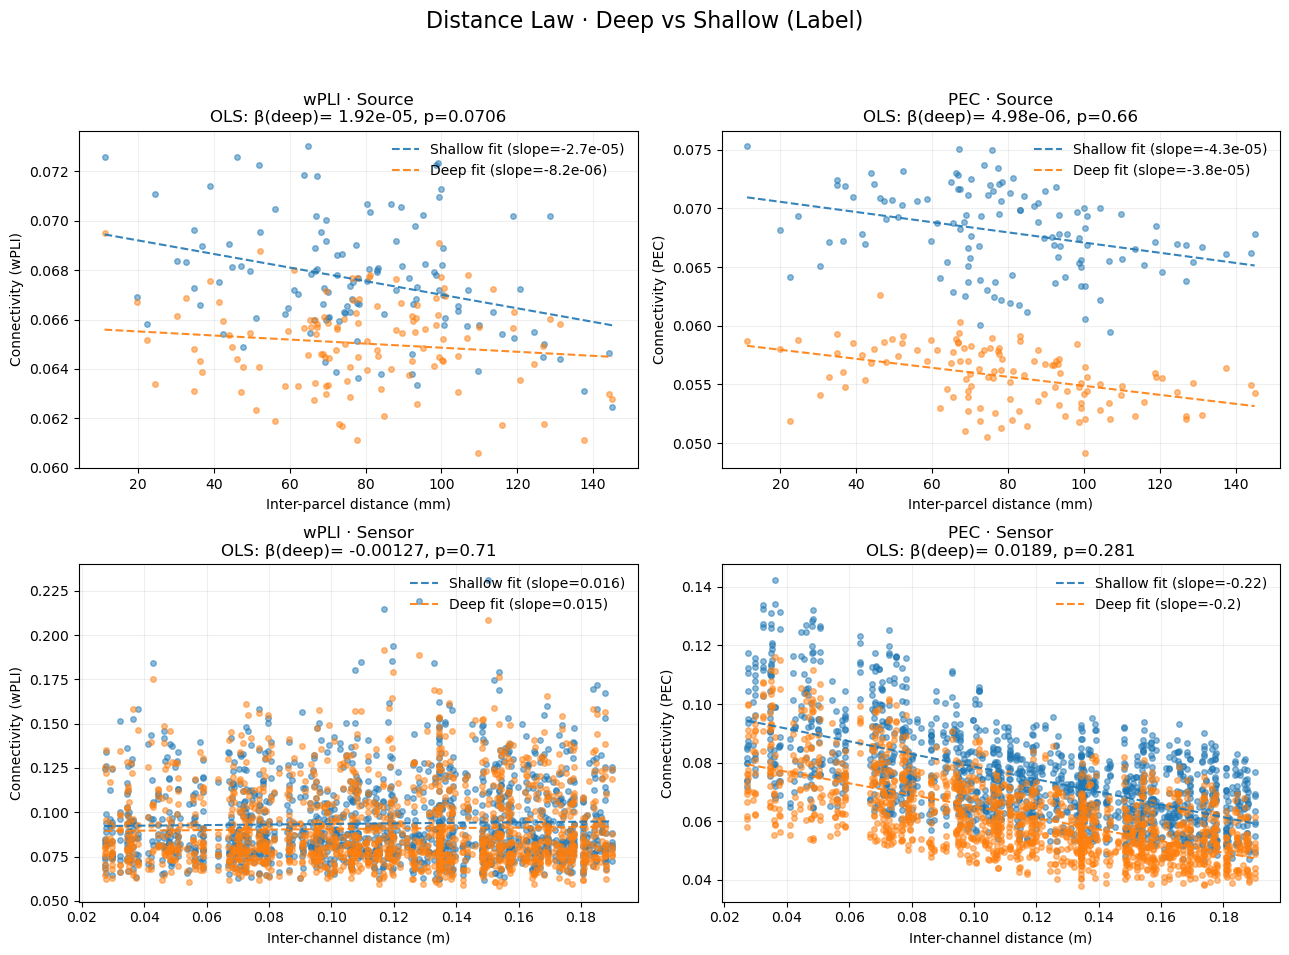

In [4]:
# PARAMS
LEVEL = 'source'
CONN_METRIC = 'correlation'
DEEP_SHALLOW = 'label'
mst_models_ols = {}
models_ols = {}

fig, ax = plt.subplots(2, 2, figsize=(13, 10))

for i, (CONN_METRIC, LEVEL) in enumerate(zip(['wpli', 'correlation', 'wpli', 'correlation'],
                                             ['source', 'source', 'sensor', 'sensor'])):
    conn_path = f'data/classification_datasets/{CONN_METRIC}_{LEVEL}.csv'
    conn = open_conn_df(conn_path, DEEP_SHALLOW)
    edge_pairs, N_nodes, i_idx, j_idx = create_edge_metadata(LEVEL)
    metrics = panelA_distance_law(conn, edge_pairs, N_nodes, i_idx, j_idx, LEVEL, CONN_METRIC, stats='ols', ax=ax[i//2, i%2])
    mst_models_ols[f'{CONN_METRIC}_{LEVEL}'] = fit_ols(metrics, ['strength', 'mst_diameter', 'leaf_frc'])
    models_ols[f'{CONN_METRIC}_{LEVEL}'] = fit_ols(metrics, ['mean_long', 'mean_short'])

# add a title to the whole figure
fig.suptitle(f"Distance Law · Deep vs Shallow ({DEEP_SHALLOW.title()})", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
mst_df = pd.DataFrame(models_ols).melt(ignore_index=False)
mst_df['beta'] = mst_df['value'].apply(lambda x: x['beta'])
mst_df['ci'] = mst_df['value'].apply(lambda x: x['ci'])
mst_df['pv'] = mst_df['value'].apply(lambda x: x['pv'])
mst_df.drop(columns='value', inplace=True)
mst_df

,variable,beta,ci,pv
mean_long,wpli_source,-0.002009,"[-0.0051973910431659665, 0.0011800797723391732]",0.216970
mean_short,wpli_source,-0.003466,"[-0.006835181724230404, -9.656990822147016e-05]",0.043785
mean_long,correlation_source,-0.012117,"[-0.019532986775338032, -0.004700314894359956]",0.001364
mean_short,correlation_source,-0.012376,"[-0.020237025277619294, -0.004515683301349941]",0.002029
mean_long,wpli_sensor,-0.002976,"[-0.008239561189284891, 0.002287362772257419]",0.267769
mean_short,wpli_sensor,-0.002769,"[-0.00765725811454414, 0.0021187507799685233]",0.266827
mean_long,correlation_sensor,-0.012511,"[-0.021692493462848333, -0.0033300250287729635]",0.007566
mean_short,correlation_sensor,-0.014453,"[-0.02618859319670136, -0.002718035176145229]",0.015782
